# Unlocking Societal Trends in Aadhaar Enrolment and Updates

This notebook analyzes Aadhaar enrolment, demographic updates, and biometric updates to uncover
societal trends, system stress signals, and policy-relevant insights using aggregated, anonymized data.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob


In [4]:
# Load enrolment data
enrolment_files = glob("api_data_aadhar_enrolment/*.csv")
df_enrol = pd.concat((pd.read_csv(f) for f in enrolment_files), ignore_index=True)


In [5]:
# Load demographic update data
demo_files = glob("api_data_aadhar_demographic/*.csv")
df_demo = pd.concat((pd.read_csv(f) for f in demo_files), ignore_index=True)


In [6]:
# Load biometric update data
bio_files = glob("api_data_aadhar_biometric/*.csv")
df_bio = pd.concat((pd.read_csv(f) for f in bio_files), ignore_index=True)


In [7]:
print("Enrolment columns:", list(df_enrol.columns))
print("Demographic columns:", list(df_demo.columns))
print("Biometric columns:", list(df_bio.columns))


Enrolment columns: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater']
Demographic columns: ['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_']
Biometric columns: ['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_']


In [8]:
for df in [df_enrol, df_demo, df_bio]:
    df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True, errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month


In [9]:
# Drop invalid dates
for df in [df_enrol, df_demo, df_bio]:
    df.dropna(subset=['date'], inplace=True)


In [10]:
enrol_state_month = (
    df_enrol
    .groupby(['state', 'year', 'month'], as_index=False)
    .sum(numeric_only=True)
)


In [11]:
# Remove numeric artifacts
enrol_state_month = enrol_state_month[
    ~enrol_state_month['state'].str.fullmatch(r'\d+')
].copy()

# Canonical state normalization
state_name_map = {
    'Andaman And Nicobar Islands': 'Andaman And Nicobar Islands',
    'Dadra And Nagar Haveli': 'Dadra And Nagar Haveli',
    'Daman And Diu': 'Daman And Diu'
}

enrol_state_month['state'] = (
    enrol_state_month['state']
    .astype(str)
    .str.strip()
    .str.replace('&', 'And', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
    .str.title()
    .replace(state_name_map)
)

# Re-aggregate after cleaning
enrol_state_month = (
    enrol_state_month
    .groupby(['state', 'year', 'month'], as_index=False)
    .sum(numeric_only=True)
)


In [12]:
enrol_state_month['total_enrolment'] = (
    enrol_state_month['age_0_5'] +
    enrol_state_month['age_5_17'] +
    enrol_state_month['age_18_greater']
)


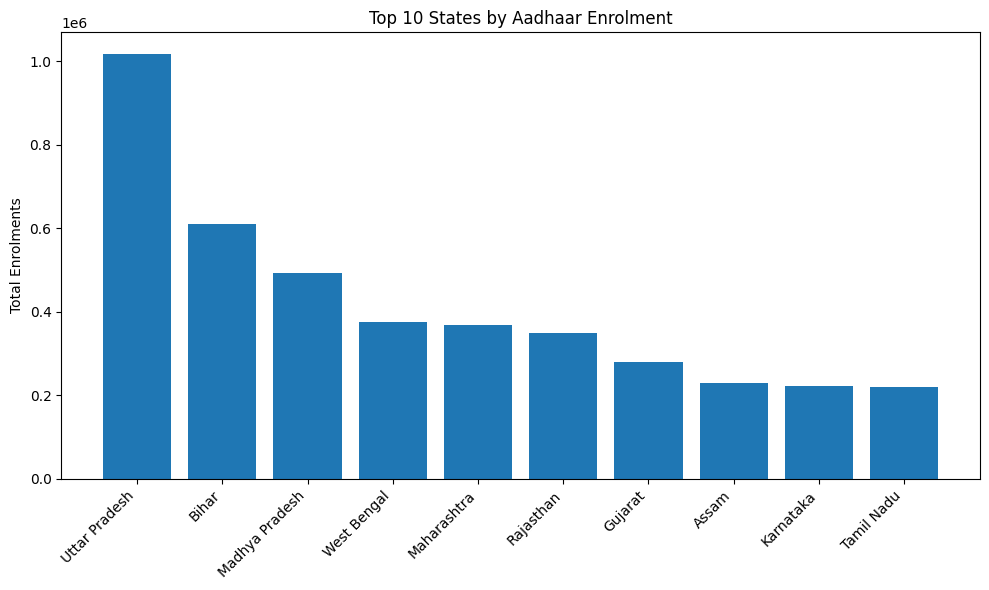

In [13]:
top_states = (
    enrol_state_month
    .groupby('state', as_index=False)['total_enrolment']
    .sum()
    .sort_values('total_enrolment', ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
plt.bar(top_states['state'], top_states['total_enrolment'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 States by Aadhaar Enrolment')
plt.ylabel('Total Enrolments')
plt.tight_layout()
plt.show()


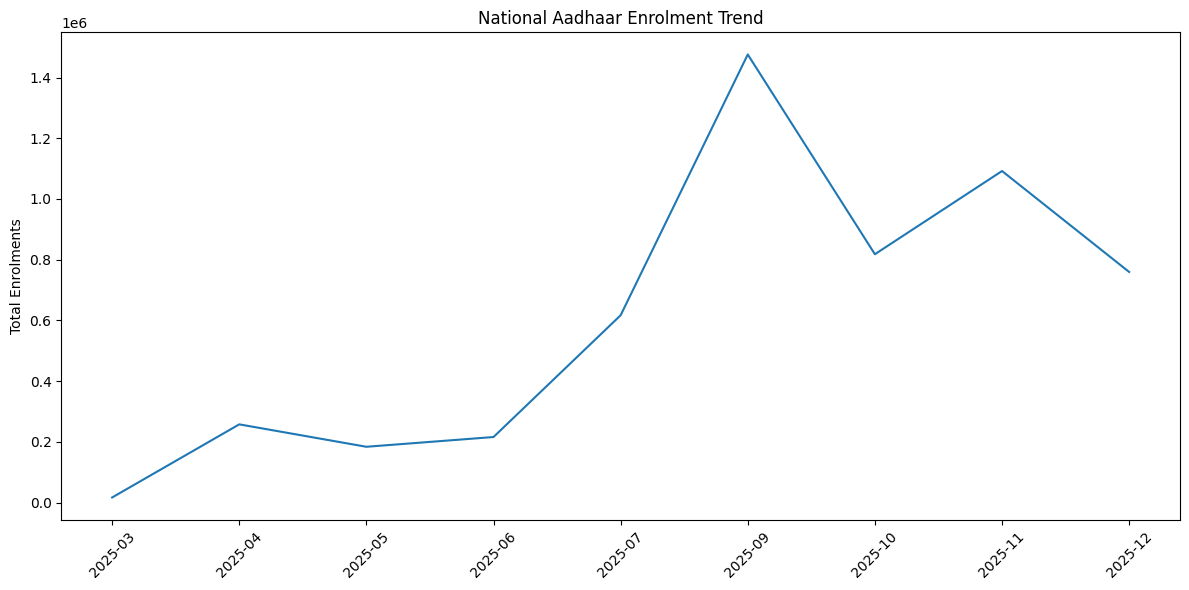

In [14]:
national_trend = (
    enrol_state_month
    .groupby(['year', 'month'], as_index=False)['total_enrolment']
    .sum()
    .sort_values(['year', 'month'])
)

national_trend['period'] = (
    national_trend['year'].astype(str) + '-' +
    national_trend['month'].astype(str).str.zfill(2)
)

plt.figure(figsize=(12, 6))
plt.plot(national_trend['period'], national_trend['total_enrolment'])
plt.xticks(rotation=45)
plt.title('National Aadhaar Enrolment Trend')
plt.ylabel('Total Enrolments')
plt.tight_layout()
plt.show()


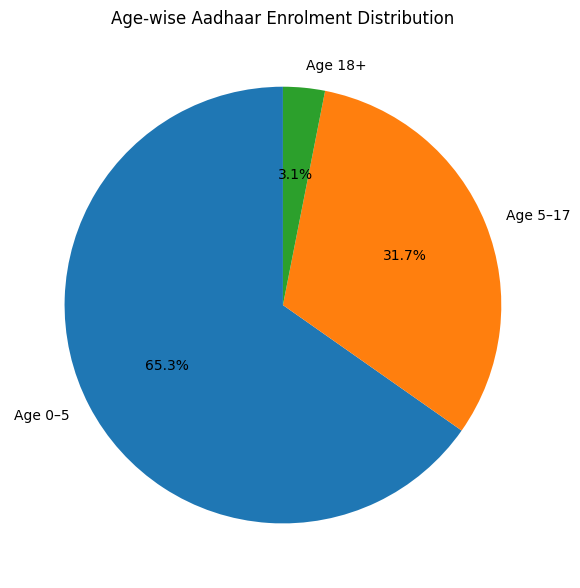

In [15]:
age_distribution = enrol_state_month[
    ['age_0_5', 'age_5_17', 'age_18_greater']
].sum().rename({
    'age_0_5': 'Age 0–5',
    'age_5_17': 'Age 5–17',
    'age_18_greater': 'Age 18+'
})

plt.figure(figsize=(6, 6))
plt.pie(age_distribution, labels=age_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Age-wise Aadhaar Enrolment Distribution')
plt.tight_layout()
plt.show()


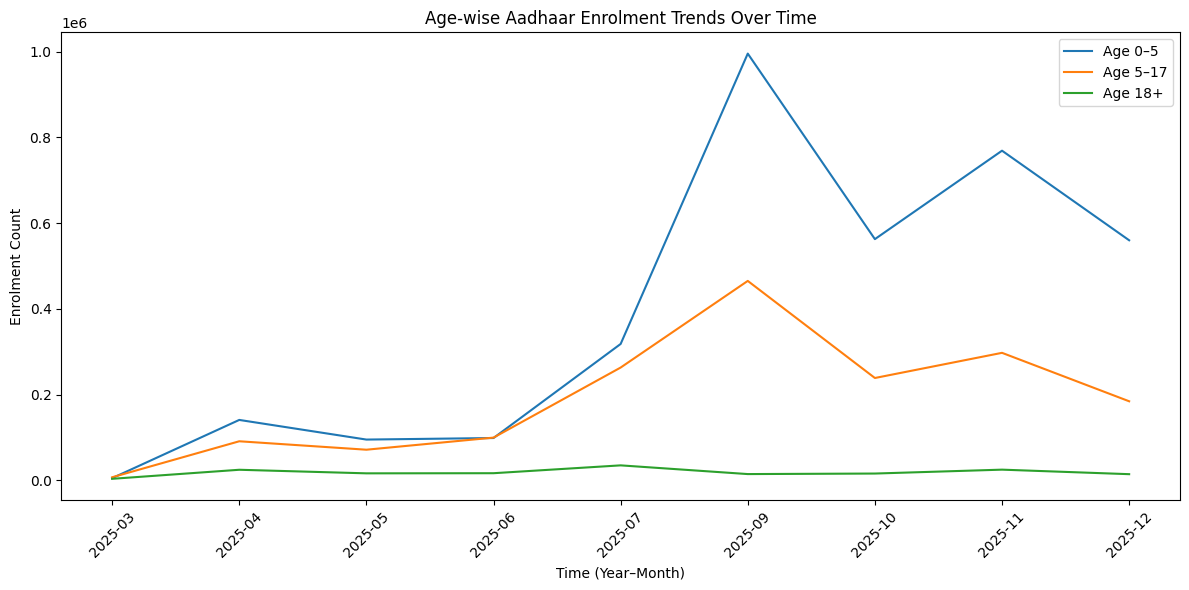

In [16]:
# Age-wise Aadhaar enrolment trend over time (national level)
age_trend = (
    enrol_state_month
    .groupby(['year', 'month'], as_index=False)
    [['age_0_5', 'age_5_17', 'age_18_greater']]
    .sum()
    .sort_values(['year', 'month'])
)

# Create a proper time label
age_trend['period'] = (
    age_trend['year'].astype(str) + '-' +
    age_trend['month'].astype(str).str.zfill(2)
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(age_trend['period'], age_trend['age_0_5'], label='Age 0–5')
plt.plot(age_trend['period'], age_trend['age_5_17'], label='Age 5–17')
plt.plot(age_trend['period'], age_trend['age_18_greater'], label='Age 18+')

plt.legend()
plt.title('Age-wise Aadhaar Enrolment Trends Over Time')
plt.xlabel('Time (Year–Month)')
plt.ylabel('Enrolment Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
demo_state_month = (
    df_demo
    .groupby(['state', 'year', 'month'], as_index=False)
    .sum(numeric_only=True)
)


In [18]:
bio_state_month = (
    df_bio
    .groupby(['state', 'year', 'month'], as_index=False)
    .sum(numeric_only=True)
)

bio_state_month[['bio_age_5_17', 'bio_age_17_']] = (
    bio_state_month[['bio_age_5_17', 'bio_age_17_']].fillna(0)
)

bio_state_month['total_bio_updates'] = (
    bio_state_month['bio_age_5_17'] + bio_state_month['bio_age_17_']
)


In [19]:
bio_national = (
    bio_state_month
    .groupby(['year', 'month'], as_index=False)['total_bio_updates']
    .sum()
    .sort_values(['year', 'month'])
)

bio_national['period'] = (
    bio_national['year'].astype(str) + '-' +
    bio_national['month'].astype(str).str.zfill(2)
)

bio_national['rolling_mean'] = (
    bio_national['total_bio_updates']
    .rolling(window=6, min_periods=3)
    .mean()
)

bio_national['deviation'] = (
    bio_national['total_bio_updates'] - bio_national['rolling_mean']
)

threshold = 2 * bio_national['deviation'].std(skipna=True)
bio_national['anomaly'] = bio_national['deviation'].abs() > threshold


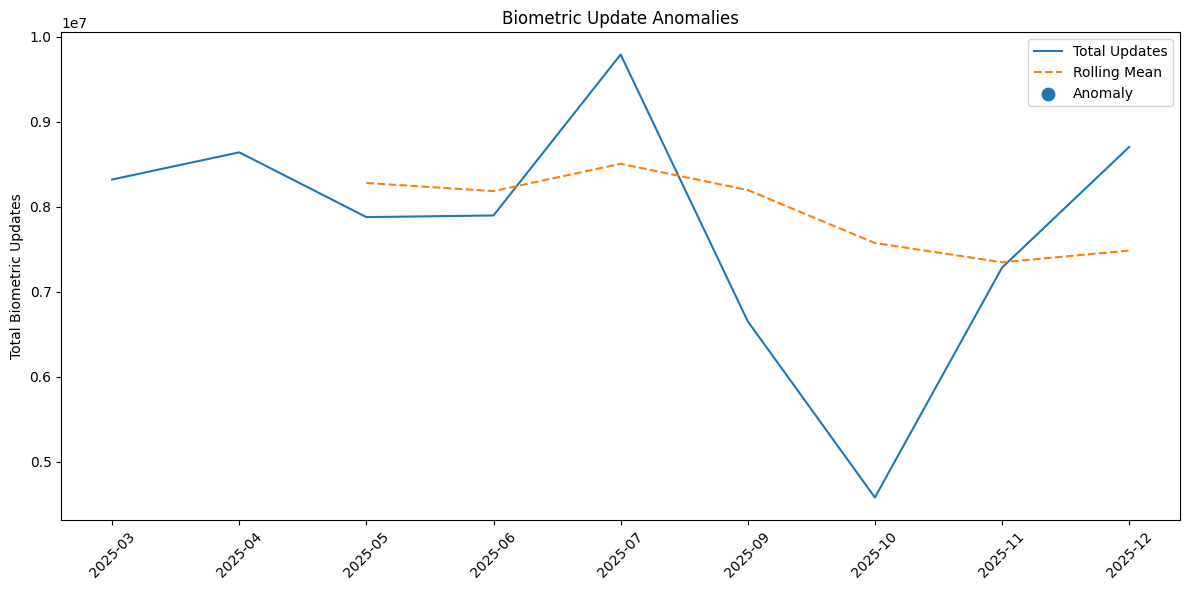

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(bio_national['period'], bio_national['total_bio_updates'], label='Total Updates')
plt.plot(bio_national['period'], bio_national['rolling_mean'], '--', label='Rolling Mean')

anomalies = bio_national[bio_national['anomaly']]
plt.scatter(anomalies['period'], anomalies['total_bio_updates'], s=80, label='Anomaly')

plt.xticks(rotation=45)
plt.title('Biometric Update Anomalies')
plt.ylabel('Total Biometric Updates')
plt.legend()
plt.tight_layout()
plt.show()


All analysis is performed on aggregated, anonymized data.
No individual-level inference or personal identification is attempted,
ensuring full compliance with UIDAI privacy principles.
